# Model Evaluation and Interpretation

interpreting the best model using lime and shap

In [33]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

import shap
import lime
import lime.lime_tabular

import warnings
warnings.filterwarnings('ignore')
sns.set_style('whitegrid')

## load model and data

In [34]:
df = pd.read_csv('data_cleaned.csv')

X = df.drop(columns=['Species'])
y = df['Species']

le = LabelEncoder()
y_encoded = le.fit_transform(y)

X_train, X_test, y_train, y_test = train_test_split(
    X, y_encoded, test_size=0.3, stratify=y_encoded, random_state=42
)

best_model = joblib.load('best_model.pkl')

print(f"loaded model: {type(best_model.best_estimator_['classifier']).__name__}")
print(f"best params: {best_model.best_params_}")
print(f"train samples: {len(X_train)}, test samples: {len(X_test)}")

loaded model: LogisticRegression
best params: {'classifier__C': 10, 'classifier__solver': 'lbfgs'}
train samples: 240, test samples: 104


## model predictions

In [35]:
y_pred = best_model.predict(X_test)
y_pred_proba = best_model.predict_proba(X_test)

print(classification_report(y_test, y_pred, target_names=le.classes_))

              precision    recall  f1-score   support

      Adelie       0.98      1.00      0.99        46
   Chinstrap       1.00      1.00      1.00        21
      Gentoo       1.00      0.97      0.99        37

    accuracy                           0.99       104
   macro avg       0.99      0.99      0.99       104
weighted avg       0.99      0.99      0.99       104



## confusion matrix

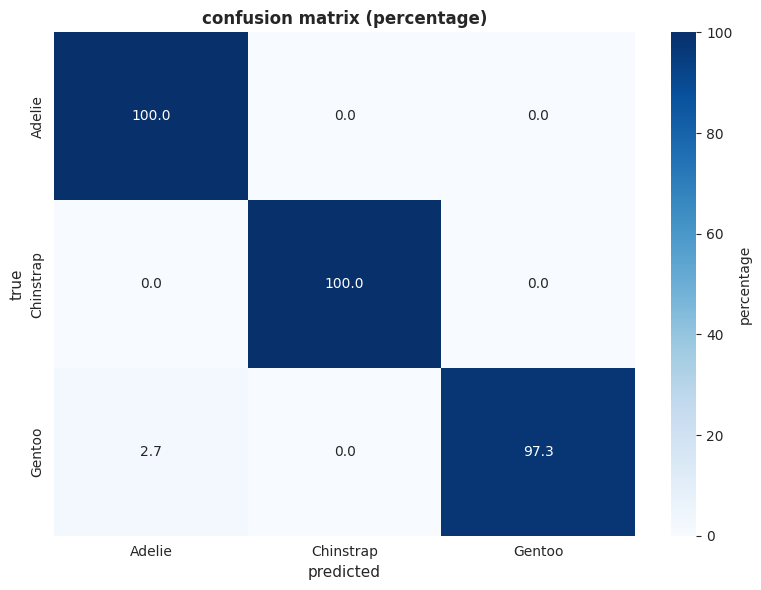

In [36]:
cm = confusion_matrix(y_test, y_pred)
cm_pct = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] * 100

fig, ax = plt.subplots(figsize=(8, 6))
sns.heatmap(cm_pct, annot=True, fmt='.1f', cmap='Blues',
            xticklabels=le.classes_, yticklabels=le.classes_, ax=ax,
            cbar_kws={'label': 'percentage'})
ax.set_xlabel('predicted', fontsize=11)
ax.set_ylabel('true', fontsize=11)
ax.set_title('confusion matrix (percentage)', fontsize=12, fontweight='bold')
plt.tight_layout()
plt.show()

## shap values

shap quantifies each feature contribution to predictions

In [37]:
shap.initjs()

explainer = shap.Explainer(best_model.predict, X_train, feature_names=list(X.columns))
shap_values = explainer(X_test)

print(f"computed shap values for {len(X_test)} test samples")

computed shap values for 104 test samples


## shap bar plot

shows mean absolute shap value per feature

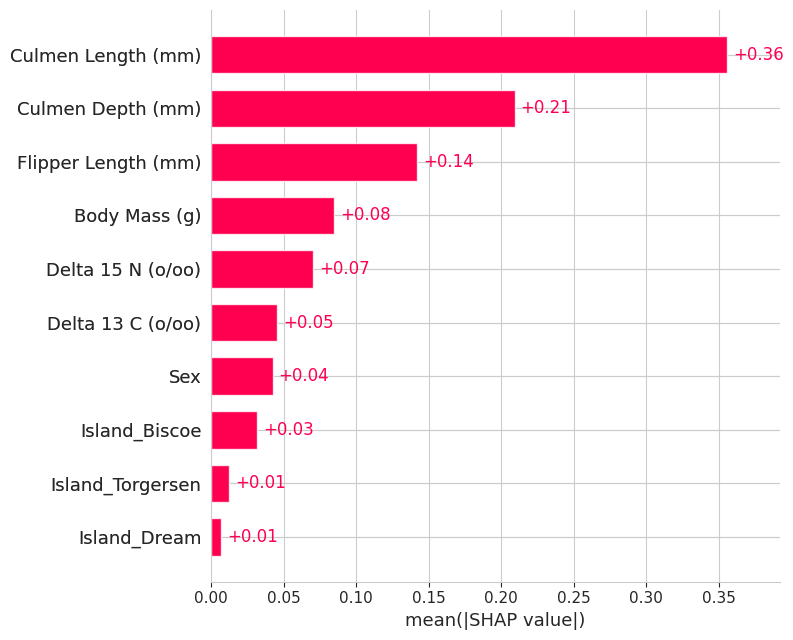

In [38]:
shap.plots.bar(shap_values, max_display=10, show=False)
plt.tight_layout()
plt.savefig('shap_bar.png', dpi=150, bbox_inches='tight')
plt.show()

## shap beeswarm plot

shows distribution of shap values - color indicates feature value (red=high, blue=low)

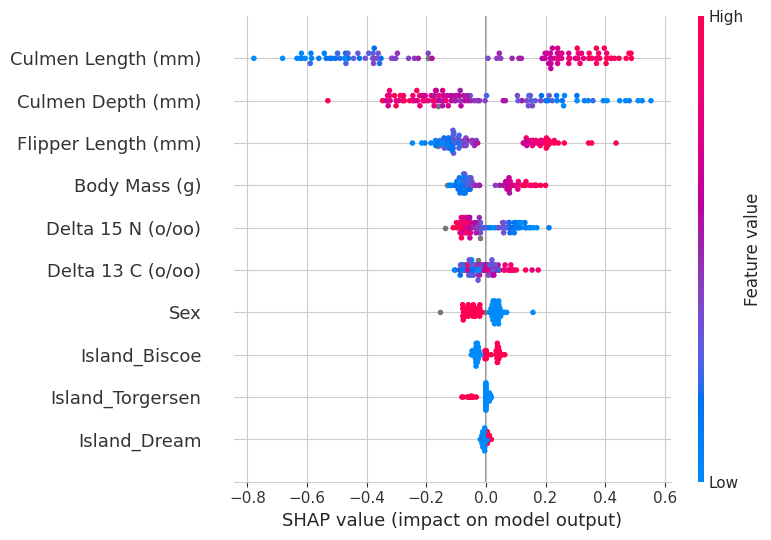

In [39]:
shap.plots.beeswarm(shap_values, max_display=10, show=False)
plt.tight_layout()
plt.savefig('shap_beeswarm.png', dpi=150, bbox_inches='tight')
plt.show()

## shap waterfall plot

shows how features push prediction from base value to final prediction for single sample

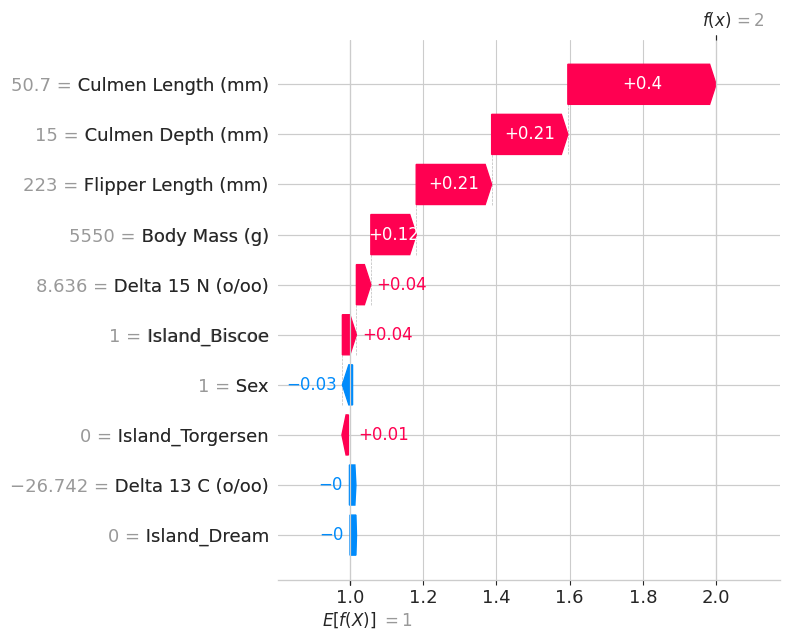

sample 0:
  true species: Gentoo
  predicted: Gentoo
  probabilities: {'Adelie': np.float64(3.331975554513895e-05), 'Chinstrap': np.float64(6.359638171429568e-06), 'Gentoo': np.float64(0.9999603206062835)}


In [40]:
sample_idx = 0
shap.plots.waterfall(shap_values[sample_idx], max_display=10, show=False)
plt.tight_layout()
plt.savefig('shap_waterfall.png', dpi=150, bbox_inches='tight')
plt.show()

print(f"sample {sample_idx}:")
print(f"  true species: {le.classes_[y_test[sample_idx]]}")
print(f"  predicted: {le.classes_[y_pred[sample_idx]]}")
print(f"  probabilities: {dict(zip(le.classes_, y_pred_proba[sample_idx]))}")

## lime interpretation

lime creates local linear approximations to explain individual predictions

In [41]:
categorical_features_indices = [X.columns.get_loc(col) for col in ['Sex', 'Island_Biscoe', 'Island_Dream', 'Island_Torgersen']]

def predict_fn(X_input):
    preprocessor = best_model.best_estimator_.named_steps['preprocessor']
    classifier = best_model.best_estimator_.named_steps['classifier']
    X_df = pd.DataFrame(X_input, columns=X.columns)
    X_transformed = preprocessor.transform(X_df)
    return classifier.predict_proba(X_transformed)

lime_explainer = lime.lime_tabular.LimeTabularExplainer(
    X_train.values,
    feature_names=list(X.columns),
    class_names=le.classes_,
    categorical_features=categorical_features_indices,
    mode='classification',
    discretize_continuous=False
)

print(f"created lime explainer")

created lime explainer


## lime explanation for sample

saved lime explanation to lime_explanation.html


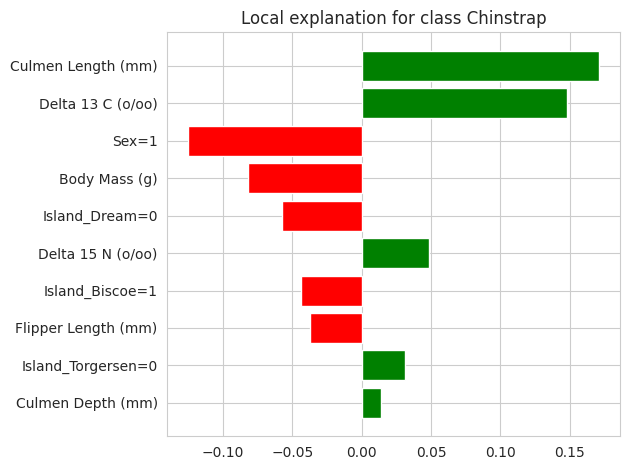


sample 0:
  true species: Gentoo
  predicted: Gentoo


In [42]:
sample_idx = 0
exp = lime_explainer.explain_instance(
    X_test.iloc[sample_idx].values,
    predict_fn,
    num_features=10
)

exp.save_to_file('lime_explanation.html')
print(f"saved lime explanation to lime_explanation.html")

fig = exp.as_pyplot_figure()
plt.tight_layout()
plt.savefig('lime_explanation.png', dpi=150, bbox_inches='tight')
plt.show()

print(f"\nsample {sample_idx}:")
print(f"  true species: {le.classes_[y_test[sample_idx]]}")
print(f"  predicted: {le.classes_[y_pred[sample_idx]]}")

## lime explanations for different species


explaining Adelie (sample 2)


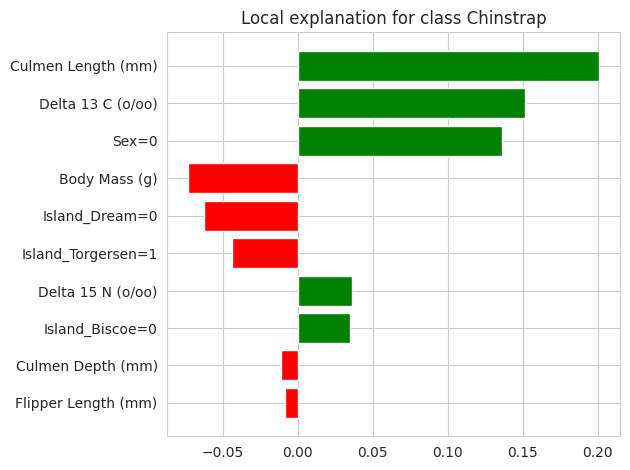

  predicted: Adelie
  probabilities: {'Adelie': np.float64(0.9998423564076563), 'Chinstrap': np.float64(0.00013221684525348428), 'Gentoo': np.float64(2.5426747090323802e-05)}

explaining Chinstrap (sample 1)


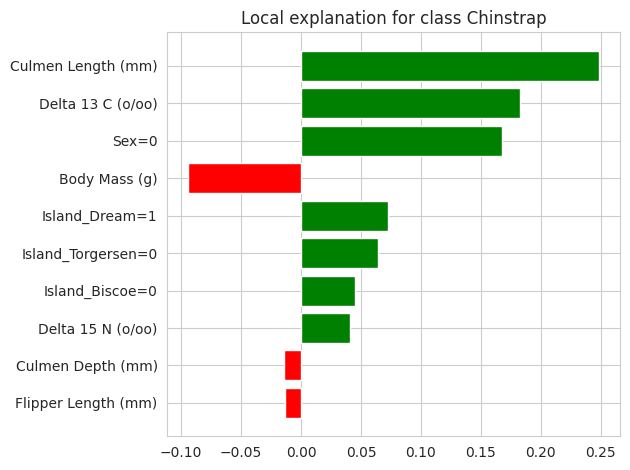

  predicted: Chinstrap
  probabilities: {'Adelie': np.float64(0.0015260877181829332), 'Chinstrap': np.float64(0.9984257330215113), 'Gentoo': np.float64(4.817926030591849e-05)}

explaining Gentoo (sample 0)


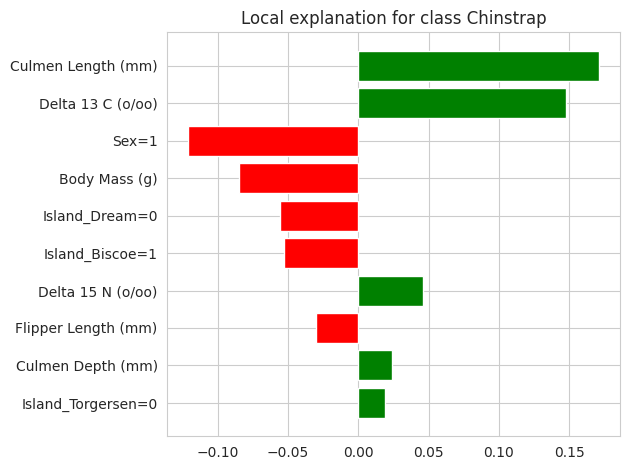

  predicted: Gentoo
  probabilities: {'Adelie': np.float64(3.331975554513895e-05), 'Chinstrap': np.float64(6.359638171429568e-06), 'Gentoo': np.float64(0.9999603206062835)}


In [43]:
species_samples = {}
for species_idx in range(3):
    idx = np.where(y_test == species_idx)[0][0]
    species_samples[le.classes_[species_idx]] = idx

for species, idx in species_samples.items():
    print(f"\nexplaining {species} (sample {idx})")
    exp = lime_explainer.explain_instance(
        X_test.iloc[idx].values,
        predict_fn,
        num_features=10
    )
    
    fig = exp.as_pyplot_figure()
    plt.tight_layout()
    plt.savefig(f'lime_{species.lower()}.png', dpi=150, bbox_inches='tight')
    plt.show()
    
    print(f"  predicted: {le.classes_[y_pred[idx]]}")
    print(f"  probabilities: {dict(zip(le.classes_, y_pred_proba[idx]))}")

## feature importance comparison

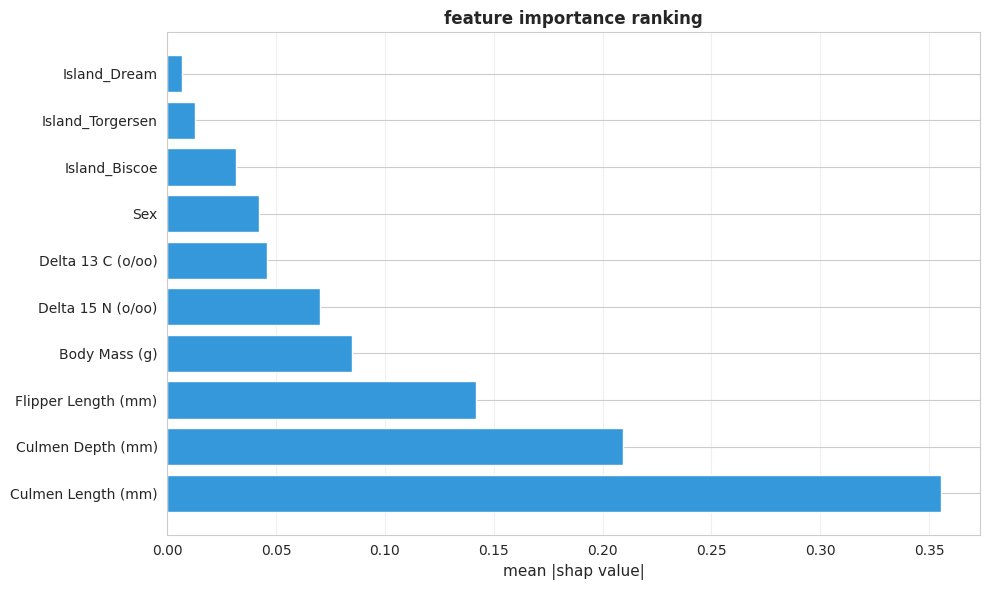


feature importance ranking:
            feature  shap_importance
 Culmen Length (mm)         0.355641
  Culmen Depth (mm)         0.209153
Flipper Length (mm)         0.141902
      Body Mass (g)         0.084808
  Delta 15 N (o/oo)         0.070289
  Delta 13 C (o/oo)         0.045676
                Sex         0.042322
      Island_Biscoe         0.031478
   Island_Torgersen         0.012630
       Island_Dream         0.006854


In [44]:
shap_importance = np.abs(shap_values.values).mean(axis=0)
if len(shap_importance.shape) > 1:
    shap_importance = shap_importance.mean(axis=1)

feature_importance_df = pd.DataFrame({
    'feature': X.columns,
    'shap_importance': shap_importance
}).sort_values('shap_importance', ascending=False)

fig, ax = plt.subplots(figsize=(10, 6))
ax.barh(range(len(feature_importance_df)), feature_importance_df['shap_importance'], color='#3498db')
ax.set_yticks(range(len(feature_importance_df)))
ax.set_yticklabels(feature_importance_df['feature'])
ax.set_xlabel('mean |shap value|', fontsize=11)
ax.set_title('feature importance ranking', fontsize=12, fontweight='bold')
ax.grid(alpha=0.3, axis='x')
plt.tight_layout()
plt.savefig('feature_importance.png', dpi=150, bbox_inches='tight')
plt.show()

print("\nfeature importance ranking:")
print(feature_importance_df.to_string(index=False))

## conclusion

